In [527]:
#Import
import os  
import re
import sys  
import json  
import nltk
import gensim
import string
import operator
import numpy as np  
import pandas as pd
import seaborn as sns
import collections,re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora, models
from sklearn.cluster import KMeans
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from pandas.io.json import json_normalize
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics import adjusted_rand_score
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style="whitegrid", color_codes=True)


%matplotlib inline


# Extract and analyze

In [2]:
#Extract
data=pd.read_csv('data.csv')


In [3]:
data.columns = ['Tweets','Handle','ID','Location','Sentiment']

In [76]:
print("The number of tweets collected from intial trial batch = {}".format(len(data)) )

The number of tweets collected from intial trial batch = 248


In [4]:
data.head()

,Tweets,Handle,ID,Location,Sentiment
0,This #job might be a great fit for you: Purcha...,khcareers,2.916861e+09,"Torrance, CA & Oakwood, GA",pos
1,"If you're looking for work in #Coppell, TX, ch...",DToolboxJobs,1.058711e+09,United States,pos
2,RT @Employ_Veterans: #Purchasing and #inventor...,geoffrey_payne,9.835086e+08,The Goldfields,neu
3,How To Write A Personal Statement For Your Res...,Cr8tiveResource,1.738476e+08,Stockport,neu
4,Looking for a #job? Join us Tuesday at #Frisco...,Stonebriar,2.063509e+08,"Frisco, Texas",neg


In [528]:
def preprocess_text(data):
    
    """
    Function to preprocess and remove stopwords from data frame
    Input type - DataFrame - data 
    Output type - DataFrame - data 
    """
    
    data['Tweets']= data['Tweets'].str.replace(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^https\s/]*))*', '').astype('str')
    data['Tweets'] = data['Tweets'].str.replace('-','')
    tweets =data['Tweets']
    data['Tweets']= list(filter(lambda x: x not in stopwords.words('english'), tweets))

    
    return data


In [530]:
#Initial preprocessing
data = preprocess_text(data)

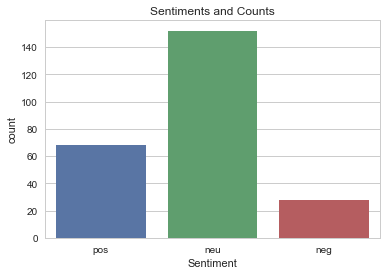

In [31]:
#Analyze sentiments count
ax = sns.countplot(x="Sentiment", data=data)
plt.title('Sentiments and Counts')
plt.show()

As expected we have neutral emotioned tweets which are actual job posts posted on Twitter,positive emotions show intent, while negative are expected to be critiques and advices in our field of study. It is apparant that there is a class imbalance between the sentiments.

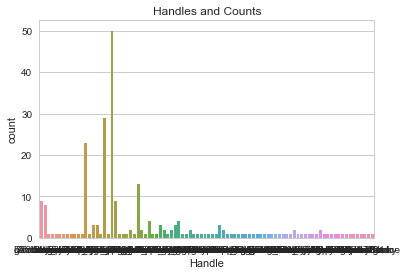

In [531]:
#Visualize the count of tweets by each handle
ax = sns.countplot(x="Handle", data=data)
plt.title('Handles and Counts')
plt.show()

From the bar chart we could see that the counts of tweets are not normalized, there could be a possible bias when a handle tweets more about our search. We could effeciently sample to remove this bias if we were to create a predictive model. The data for us are the tweets. The intial step would involve transformation of words in the corpus into numerical feature vectors inorder to implement Machine Learning algorithms

# Word Analysis

In this section we analyze the tweets even more. We look for possible patterns, create bigrams and trigrams and create a co occurance matrix to analyze the common pairs of words in our search

In [532]:
#What words other our search query are important- Major_words excludes job search
major_words = [word for word in data['Tweets'] if 'jobsearch' not in word.lower()]

In [533]:
# Naive Bigram and trigram analysis
bigrams = [(ele, tex.split()[i+1]) for tex in data['Tweets']  for i,ele in enumerate(tex.split()) if i < len(tex.split())-1]
Trigrams = [(ele, tex.split()[i+1],tex.split()[i+2]) for tex in data['Tweets']  for i,ele in enumerate(tex.split()) if i < len(tex.split())-2]  

Now we have grouped Bigrams and Trigrams together, but we are unsure how important each pairs are

## Processing functions

In [106]:
#Excluding emoticons that people might include in their tweets
emoticons_str = r"""(?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

In [356]:
#Creating a regex with emoticons and other junk characters
regex_str = [emoticons_str,r'<[^>]+>', # HTML tags
r'(?:@[\w_]+)', # @-mentions
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
r'(?:[\w_]+)', # other words
r'(?:\S)' # anything else
]

In [534]:
#Create stop word filter
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', '...', 'RT'] + regex_str

In [402]:
#Storing words without the characters that we set as unimportant
major_filt_words = [word for word in data['Tweets'] if word.lower() not in stop]

In [314]:
def tokenize(s):
    #Tokenize each string and return
        return tokens_re.findall(s)

In [313]:
def preprocess(s, lowercase=False):
        tokens = tokenize(s)
        if lowercase:
            tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        return tokens

# Unigram Analysis

In this section we perform unigram analysis and perform term and hastag frequency analysis

In [535]:
# Count hashtags
terms_hash = [term for term in tokenize(str(major_filt_words)) if term.startswith('#')]
# Count terms 
terms_only = [term for term in tokenize(str(major_filt_words)) if term not in stop and not term.startswith(('#', '@'))] 

In [536]:
#Create counter object
count_all = Counter()
count_all.update(terms_hash)
Hash_top =pd.DataFrame(count_all.most_common(10))

In [372]:
Hash_top.columns = ['Hashtags','Count']

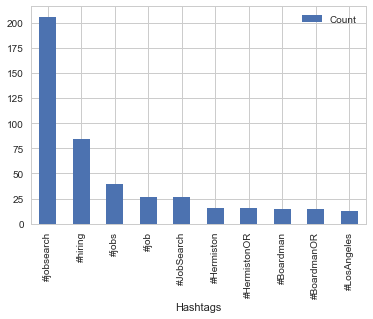

In [373]:
#Top hashtags
Hash_top.plot(x='Hashtags', y='Count', kind='bar')
plt.show()

In [404]:
count_term = Counter()
count_term.update(terms_only)
Term_top =pd.DataFrame(count_term.most_common(10))

In [405]:
Term_top.columns = ['Terms','Count']

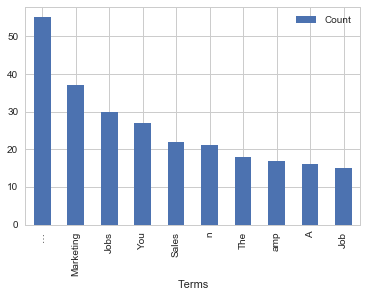

In [406]:
#Top hashtags
Term_top.plot(x='Terms', y='Count', kind='bar')
plt.show()

# Bigram Analysis 

In this section we perform bigram analysis. We analyze cooccurance of words and look for possible patterns

In [408]:
# Cocoocurence matrix
com = defaultdict(lambda : defaultdict(int))
search_item= 'Jobs'
count_search = Counter()
# Iterate through our tweets and identify cooccurence of words
for tweet in data['Tweets']:
    terms_only = [term for term in preprocess(tweet) if term not in stop and not term.startswith(('#', '@'))]
    if search_item in terms_only:
            count_search.update(terms_only)
    for i in range(len(terms_only)-1):
        for j in range(i+1, len(terms_only)):
            w1, w2 = sorted([terms_only[i], terms_only[j]])
            if w1 != w2:
                com[w1][w2] += 1

In [538]:
#Look up for co occuring items
com_max = []
for t1 in com:
        t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
        for t2, t2_count in t1_max_terms:
            com_max.append(((t1, t2), t2_count))
        
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
terms_max= pd.DataFrame(terms_max)
print("Top co-occuring items")
terms_max.columns= ['Pairs','Count']
terms_max [:5]

Top co-occuring items


,Pairs,Count
0,"(Jobs, Marketing)",27
1,"(You, …)",20
2,"(You, amp)",17
3,"(Driver, You)",15
4,"(Marketing, Sales)",15


In [537]:
print("Top co-occuring items for keyword {} =".format(search_item) )
Top_search= pd.DataFrame(count_search.most_common(10))
Top_search.columns =['Terms','Count']
Top_search[:10]

Top co-occuring items for keyword Jobs =


,Terms,Count
0,Jobs,30
1,Marketing,27
2,Manager,7
3,And,7
4,Sales,5
5,Director,5
6,Specialist,4
7,k,4
8,9,4
9,Digital,4


# Transformation and Clustering using Machine Learning approaches

In [539]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(major_words)

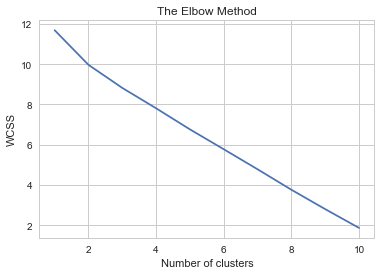

In [428]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


From the elbow method we can approximate that 2 clusters is probably the right number of clusters for this corpus

The data collected was very sparse and hence a TruncatedSVD was used instead of PCA. Truncated SVD is ideaal for dimensionality reduction in sparse dataset

In [434]:
SVD = TruncatedSVD(n_components=2).fit(X)
SVD_2d = pca.transform(X)


In [540]:
#Kmeans clustering
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [444]:
print("Top terms for each of our Kmeans clusters:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms for each of our Kmeans clusters:
Cluster 0:
 jobs
 rt
 helpful
 information
 job
 resume
 video
 apply
 today
 did
Cluster 1:
 wall
 don
 beating
 time
 spend
 evocoach1
 rt
 youtern
 gethired
 does


## Visualize clusters

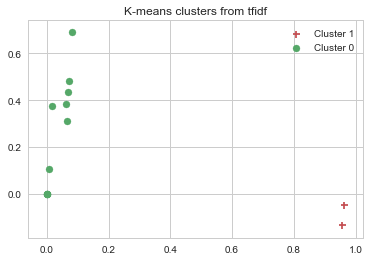

In [443]:
for i in range(0, SVD_2d.shape[0]):
    if model.labels_[i] == 1:
         clus1 = plt.scatter(SVD_2d[i,0],SVD_2d[i,1],c='r',marker='+')
    if model.labels_[i] == 0:
         clus2 = plt.scatter(SVD_2d[i,0],SVD_2d[i,1],c='g',marker='o')
    plt.legend([clus1, clus2],['Cluster 1', 'Cluster 0'])
    plt.title('K-means clusters from tfidf')
plt.show()

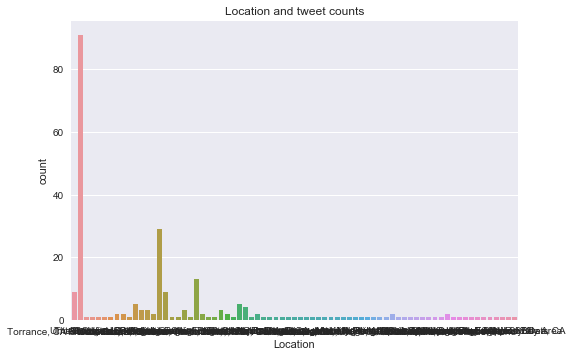

In [454]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Location", data=data)
plt.title('Location and tweet counts')
plt.show()

A more detailed location analysis can be done using Cartograms and heatmaps

# Topic Modelling using Latent Dirichlet allocation (LDA)

In this section we follow NLP approaches to look for possible topics from our tweet corpus. LDA has been chosen for our analysis ahead of Latent Semantic Analysis, since LDA has been proven to be more accurate eventhough it takes some time to train

In [518]:
#Tokenize and stem
tokenizer = RegexpTokenizer(r'\w+')
corp= major_filt_words
p_stemmer = PorterStemmer()

#Create tokenized document list
tokenized = []

for i in corp:
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    #Stemming
    stemtokens = [p_stemmer.stem(i) for i in tokens]
    # append tokens 
    tokenized.append(stemtokens)


In [520]:
#Id2word dictionary
id2word = corpora.Dictionary(tokenized)


In [521]:
#Document term matrix
doc_term = [id2word.doc2bow(text) for text in tokenized]

In [522]:
#Model
ldamodel = gensim.models.ldamodel.LdaModel(doc_term, num_topics=20, id2word = id2word, passes=20)

Find most contributing words for 10 randomly selected topics

In [524]:
ldamodel.print_topics(10)


[(3,
  '0.057*"jobsearch" + 0.032*"you" + 0.030*"hire" + 0.027*"contractor" + 0.027*"mommyjobsonlin" + 0.027*"agent" + 0.027*"independ" + 0.026*"custom" + 0.026*"servic" + 0.026*"boardmanor"'),
 (10,
  '0.034*"your" + 0.022*"jobsearch" + 0.022*"job" + 0.022*"you" + 0.022*"linkedin" + 0.022*"success" + 0.022*"myth" + 0.022*"with" + 0.012*"rt" + 0.012*"a"'),
 (13,
  '0.070*"job" + 0.063*"jobsearch" + 0.024*"hire" + 0.018*"post" + 0.017*"market" + 0.017*"ca" + 0.014*"in" + 0.014*"from" + 0.014*"friend" + 0.014*"jobreport"'),
 (8,
  '0.081*"job" + 0.071*"jobsearch" + 0.034*"market" + 0.025*"hire" + 0.023*"and" + 0.023*"losangel" + 0.023*"losangelesca" + 0.016*"manag" + 0.014*"in" + 0.014*"angel"'),
 (11,
  '0.048*"job" + 0.043*"jobsearch" + 0.031*"you" + 0.027*"a" + 0.023*"in" + 0.019*"rt" + 0.017*"ny" + 0.016*"for" + 0.016*"applynow" + 0.016*"melbourn"'),
 (17,
  '0.050*"to" + 0.044*"need" + 0.044*"you" + 0.044*"tip" + 0.040*"jobsearch" + 0.038*"that" + 0.038*"5" + 0.031*"know" + 0.031*"t

This model can be used to train on new unseen documents(Tweets). More exploration on this model can give better topic level association between the tweets

Future approaches:
1. Other that this data can be visualized dynamically so that whenever the Spark Parquet drops a new stream file the data is visualized and a more intuitive geographical and word level association can be made visually
2. Creating heatmaps can also enable us to analyze the tweet frequency
3. Ranking algorithms like Pagerank can also be used to rank 
4. The sentimental analysis algorithm results can be used as a penalizing factor to create more effective ranking of the tweets and job information